# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
import matplotlib
matplotlib.use('Agg')

# Batch convert raw files into pickle

In [3]:
from mna.utils.rnapp_data_format import read_all_files

In [4]:
read_all_files(data_dir='/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/In-Lab_Recordings/',
               pickle_dir='/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/', save_pickle=True)

processing file 08_07_2022_09_29_24-Exp_adadrive-Sbj_09-Ssn_02.dats
processing file .DS_Store%


Process SpawnPoolWorker-4:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/sharathckoo/opt/miniconda3/envs/mna/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/sharathckoo/opt/miniconda3/envs/mna/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/sharathckoo/opt/miniconda3/envs/mna/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/sharathckoo/opt/miniconda3/envs/mna/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/Users/sharathckoo/opt/miniconda3/envs/mna/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/U

# Batch analysis

In [5]:
# read_all_files(data_dir = './../In-Lab Recordings/')
from os import listdir
from os.path import isfile, join

data_dir = "/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
all_dfs=None
for each_file in onlyfiles:
    input_path = data_dir + each_file

    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data)
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'
    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                            value=[1, 2, None])

    summary_statistics['trial_count'] = (event_df.block_condition!='practice').sum()
    summary_statistics['hard_trials_rate'] = (event_df.spoken_difficulty=='hard').sum()/event_df.spoken_difficulty.notnull().sum()

    # ecg
    post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

    # eye
    post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,plot_frequency=20, plot_eye_snippet=40)

    # eeg
    post_processed_event_df, epochs, events, event_dict, info, reject_log, ica = process_session_eeg(rns_data, post_processed_event_df,
                                                                    event_column='spoken_difficulty_encoded', run_autoreject=True, run_ica=True)

    # motor
    post_processed_event_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)


    # save
    post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    if not type(all_dfs)==pd.core.frame.DataFrame:
        all_dfs = post_processed_event_df
    else:
        all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)

Computed velocity exceeds threshold. Inappropriate filter setup? [1581.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1838.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1434.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1085.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2063.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2034.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2596.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1007.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2303.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1804.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1746.2 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3258156
    Range : 0 ... 3258155 =      0.000 ...  1590.896 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
21 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1031.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1541.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1534.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1086.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2434.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1791.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1535.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1159.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1292.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2278.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2367.9 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2966066
    Range : 0 ... 2966065 =      0.000 ...  1448.274 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
58 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1132.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1113.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1644.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1632.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1492.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2342.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1646.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1531.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2600.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2540.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1594.5 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3142493
    Range : 0 ... 3142492 =      0.000 ...  1534.420 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
39 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1082.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1128.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1390.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1255.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2692.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1029.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1522.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1342.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1273.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1001.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1045.6 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=4372078
    Range : 0 ... 4372077 =      0.000 ...  2134.803 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
13 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1500.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1469.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1659.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1327.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1083.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1198.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1079.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1316.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1323.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1752.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1205.7 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=4118579
    Range : 0 ... 4118578 =      0.000 ...  2011.024 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
5 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

Computed velocity exceeds threshold. Inappropriate filter setup? [2221.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2264.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2404.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2087.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3049.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1799.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1874.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1697.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1873.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2049.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2071.4 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3767934
    Range : 0 ... 3767933 =      0.000 ...  1839.811 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
30 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1554.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1799.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1083.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1221.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1645.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1495.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1741.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1924.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1954.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2168.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1314.0 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=1706522
    Range : 0 ... 1706521 =      0.000 ...   833.262 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
4 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

Computed velocity exceeds threshold. Inappropriate filter setup? [1384.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1464.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1124.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1579.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1220.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1071.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1064.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1205.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1302.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2323.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1254.1 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2771639
    Range : 0 ... 2771638 =      0.000 ...  1353.339 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
4 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

Computed velocity exceeds threshold. Inappropriate filter setup? [1004.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1039.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2690.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2675.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2675.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1110.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1215.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2939.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3280.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1156.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1043.5 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3030524
    Range : 0 ... 3030523 =      0.000 ...  1479.748 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
14 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1175.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1030.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1169.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1101.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1226.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2591.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2291.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1891.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2159.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2043.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2327.2 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3214558
    Range : 0 ... 3214557 =      0.000 ...  1569.608 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
22 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1278.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1018.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2570.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1886.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2249.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1164.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1072.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1111.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1965.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1561.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1122.2 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3484762
    Range : 0 ... 3484761 =      0.000 ...  1701.543 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
31 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [2919.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1595.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1595.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2169.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1496.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1480.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1255.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1608.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2209.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2260.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1086.2 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3734440
    Range : 0 ... 3734439 =      0.000 ...  1823.457 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
48 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

Computed velocity exceeds threshold. Inappropriate filter setup? [1601.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2265.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2301.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1772.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1418.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1396.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1176.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1036.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2264.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1849.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1697.6 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3827670
    Range : 0 ... 3827669 =      0.000 ...  1868.979 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
27 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

# Save results and generate interactive PivotTable

In [6]:
from pivottablejs import pivot_ui
all_dfs.to_csv(f"{output_dir}all_results.csv")
all_dfs.to_excel(f"{output_dir}all_results.xlsx")
pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

In [45]:
all_dfs = pd.read_excel(f"{output_dir}all_results.xlsx")

-0.9568055956915487


Text(0.5, 1.0, 'Proportional time into the trial when voice feedback was recognized')

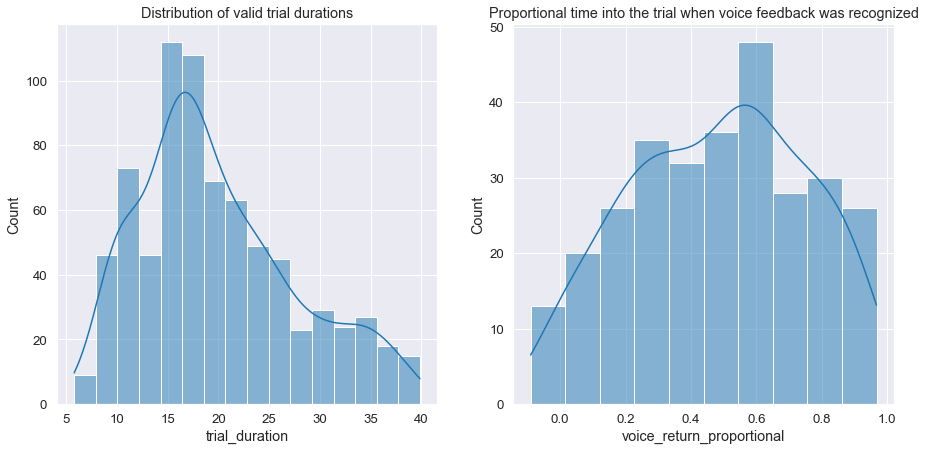

In [66]:
%matplotlib inline

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

all_dfs_final = all_dfs.copy()
all_dfs_final = all_dfs_final[all_dfs_final.trial_duration <= 40]
all_dfs_final.voice_timestamp = all_dfs_final.voice_timestamp - 1
all_dfs_final['voice_return_proportional'] = (all_dfs_final.voice_timestamp-all_dfs_final.trial_start_time)/(all_dfs_final.trial_end_time-all_dfs_final.trial_start_time)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, ax=axs[0])
sns.histplot(data=all_dfs_final, x="voice_return_proportional", kde=True, ax=axs[1])
axs[0].set_title('Distribution of valid trial durations')
axs[1].set_title('Proportional time into the trial when voice feedback was recognized')

# Misc Plots

In [56]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")

# remove practice trials
all_dfs_final = all_dfs.copy()
all_dfs_final = all_dfs_final[all_dfs_final.block_condition!='practice']

all_dfs_final['ppid_session'] = all_dfs_final['ppid'].astype(int).astype(str) + '_' + \
                                            + all_dfs_final['session'].astype(int).astype(str)

all_dfs_final.columns = all_dfs_final.columns.str.replace('.','_')
all_dfs_final.columns = all_dfs_final.columns.str.replace('measures_','')
all_dfs_final.columns = all_dfs_final.columns.str.replace("Band_Power", "Power")


cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                     "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                     "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','L Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn35'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

# rename columns
all_dfs_final = all_dfs_final.rename(columns={"Left Pupil Trial Average Diameter": "L Pupil Diameter"})

# remove trials that are too long
all_dfs_final = all_dfs_final[all_dfs_final.trial_duration <= 40]


# nan, outliers
for col in cols_of_interest:
    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)
all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>200))

In [57]:
# quality measurse
speech_recognition = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['spoken_difficulty'].notnull().mean()))
display('speech_recognition_min',speech_recognition.min().values,
        'speech_recognition_max',speech_recognition.max(),
        'speech_recognition.mean', speech_recognition.mean())
autorejected = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: np.nansum(x['autorejected'])/len(x['autorejected'])))
display('autorejected_trials_min',autorejected.min(),
        'autorejected_trials_max',autorejected.max(),
        'autorejected_trials_mean', autorejected.mean())
bad_beats = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['removed_beat_rate']))
display('bad_beats_perc_min',bad_beats.min(),
        'bad_beats_perc_max',bad_beats.max(),
        'bad_beats_perc_mean', bad_beats.mean())
speech_recognition

'speech_recognition_min'

array([0.])

'speech_recognition_max'

0    0.594595
dtype: float64

'speech_recognition.mean'

0    0.319198
dtype: float64

'autorejected_trials_min'

0    0.0
dtype: float64

'autorejected_trials_max'

0    0.408163
dtype: float64

'autorejected_trials_mean'

0    0.132453
dtype: float64

'bad_beats_perc_min'

removed_beat_rate    0.0
dtype: float64

'bad_beats_perc_max'

removed_beat_rate    0.75
dtype: float64

'bad_beats_perc_mean'

removed_beat_rate    0.243993
dtype: float64

,0
ppid_session,
10_1,0.594595
10_2,0.518519
10_3,0.518182
11_1,0.000000
32_1,0.277778
7_1,0.409091
7_2,0.469388
7_3,0.537037
8_1,0.125000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


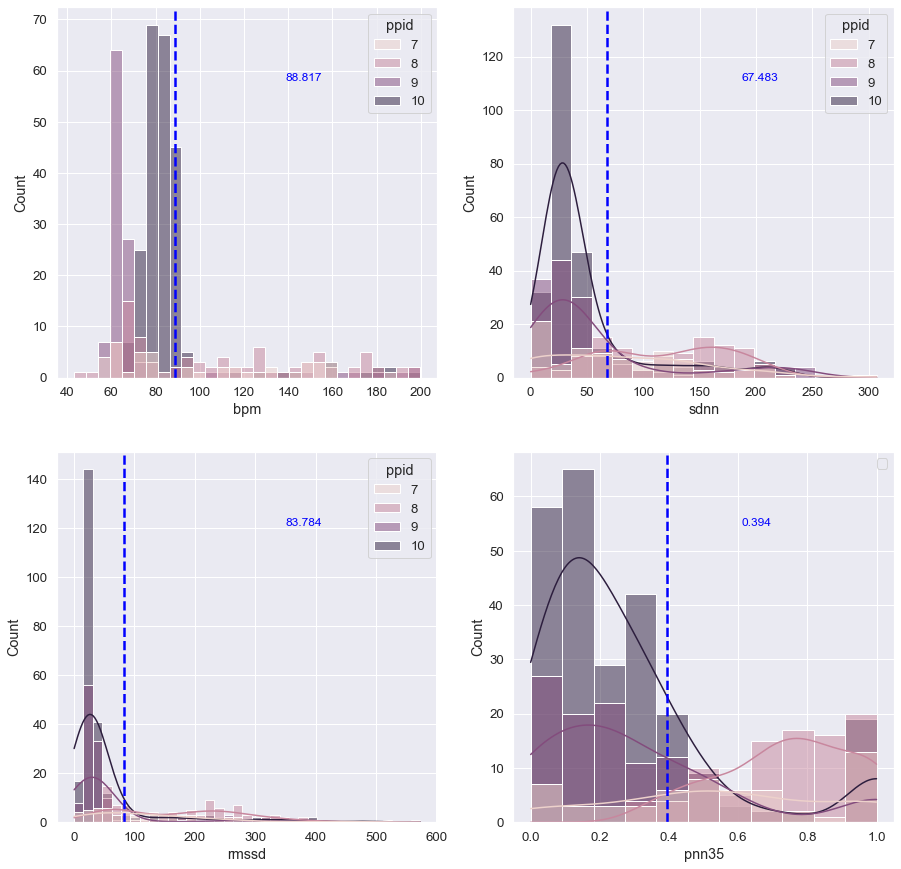

In [138]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="bpm", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
axs[0, 0].axvline(x=all_dfs_final.bpm.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.bpm.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="sdnn", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
axs[0, 1].axvline(x=all_dfs_final.sdnn.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.sdnn.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="rmssd", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
axs[1, 0].axvline(x=all_dfs_final.rmssd.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.rmssd.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="pnn35", kde=True, color="teal", ax=axs[1, 1], hue='ppid')
axs[1, 1].axvline(x=all_dfs_final.pnn35.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.pnn35.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


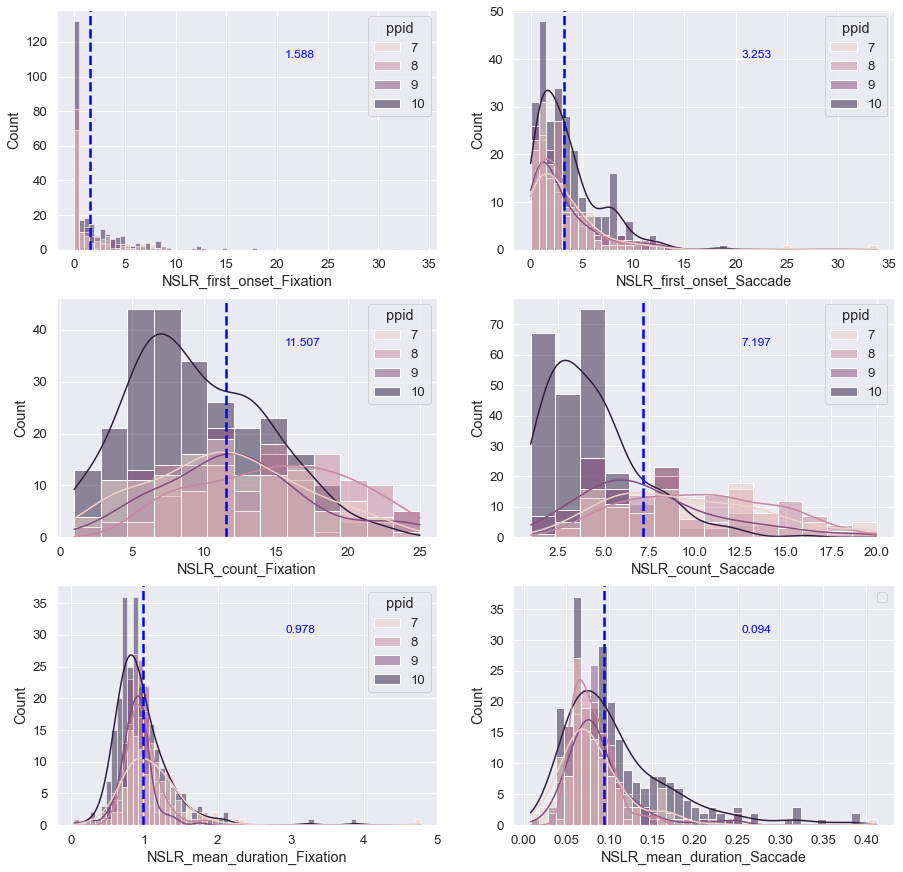

In [139]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Fixation", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
axs[0, 0].axvline(x=all_dfs_final.NSLR_first_onset_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Saccade", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
axs[0, 1].axvline(x=all_dfs_final.NSLR_first_onset_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Fixation", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
axs[1, 0].axvline(x=all_dfs_final.NSLR_count_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.NSLR_count_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Saccade", kde=True, color="teal", ax=axs[1, 1], hue='ppid')
axs[1, 1].axvline(x=all_dfs_final.NSLR_count_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.NSLR_count_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Fixation", kde=True, color="gold", ax=axs[2, 0], hue='ppid')
axs[2, 0].axvline(x=all_dfs_final.NSLR_mean_duration_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 0].text(0.6,.8, round(all_dfs_final.NSLR_mean_duration_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[2, 0].transAxes)

sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Saccade", kde=True, color="teal", ax=axs[2, 1], hue='ppid')
axs[2, 1].axvline(x=all_dfs_final.NSLR_mean_duration_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 1].text(.6,.8, round(all_dfs_final.NSLR_mean_duration_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[2, 1].transAxes)

plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


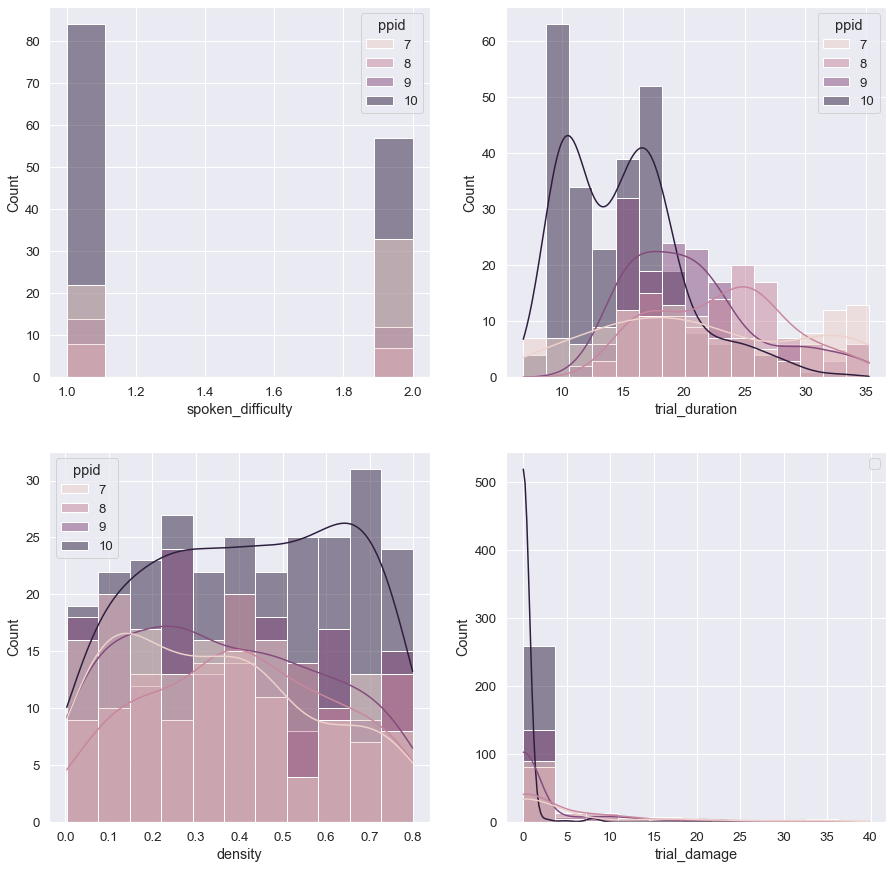

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="spoken_difficulty", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
sns.histplot(data=all_dfs_final, x="density", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
sns.histplot(data=all_dfs_final, x="trial_damage", kde=True, color="teal", ax=axs[1, 1], hue='ppid')

plt.legend() 
plt.show()


## Josef's variables

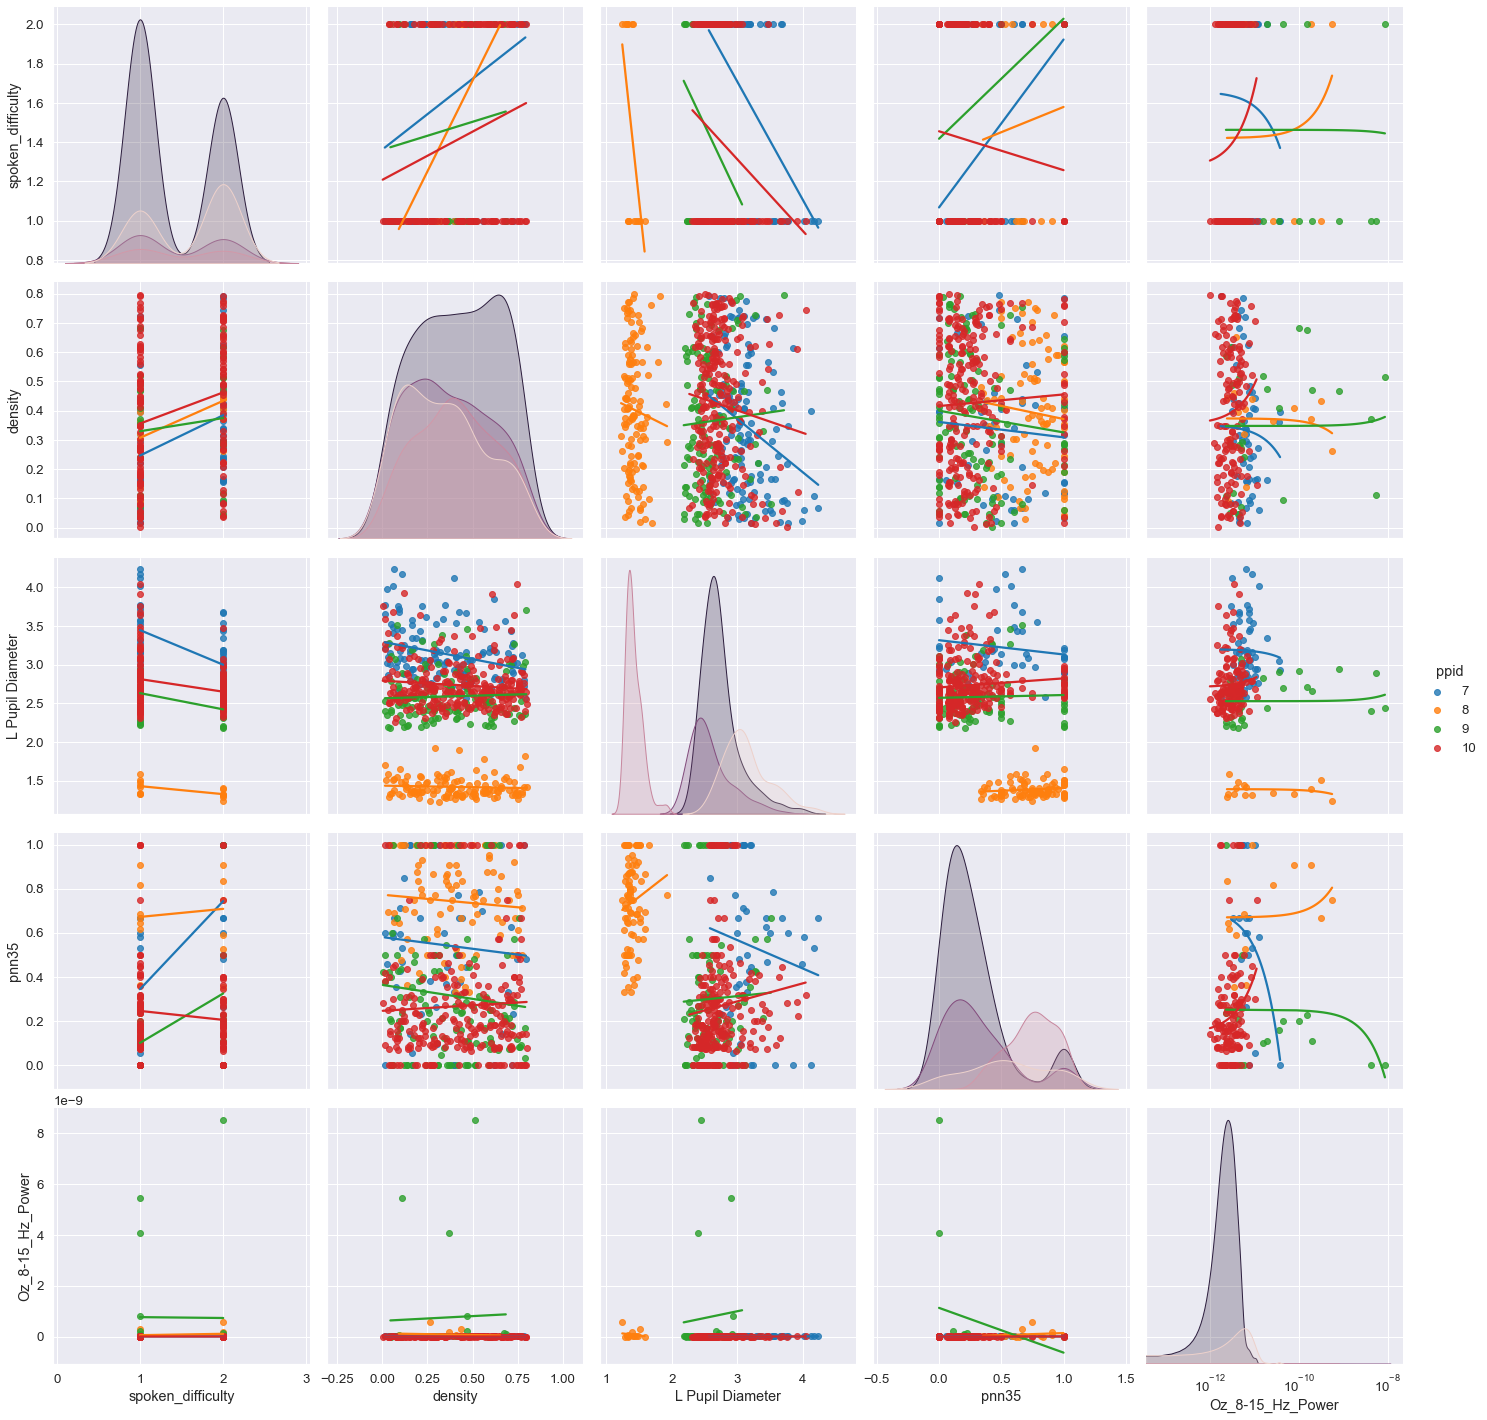

In [137]:

all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'unknown', 'spoken_difficulty'] = np.NAN

all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)

# josef_cols cols
josef_cols = ['spoken_difficulty', 'density',"L Pupil Diameter",  'pnn35', "Oz_8-15_Hz_Power"]

g = sns.pairplot(all_dfs_final[josef_cols+['ppid']], kind="reg", vars=josef_cols,
                 diag_kind="kde",height=4, hue="ppid", plot_kws=dict(ci=None))
log_columns = ["Oz_8-15_Hz_Power"]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

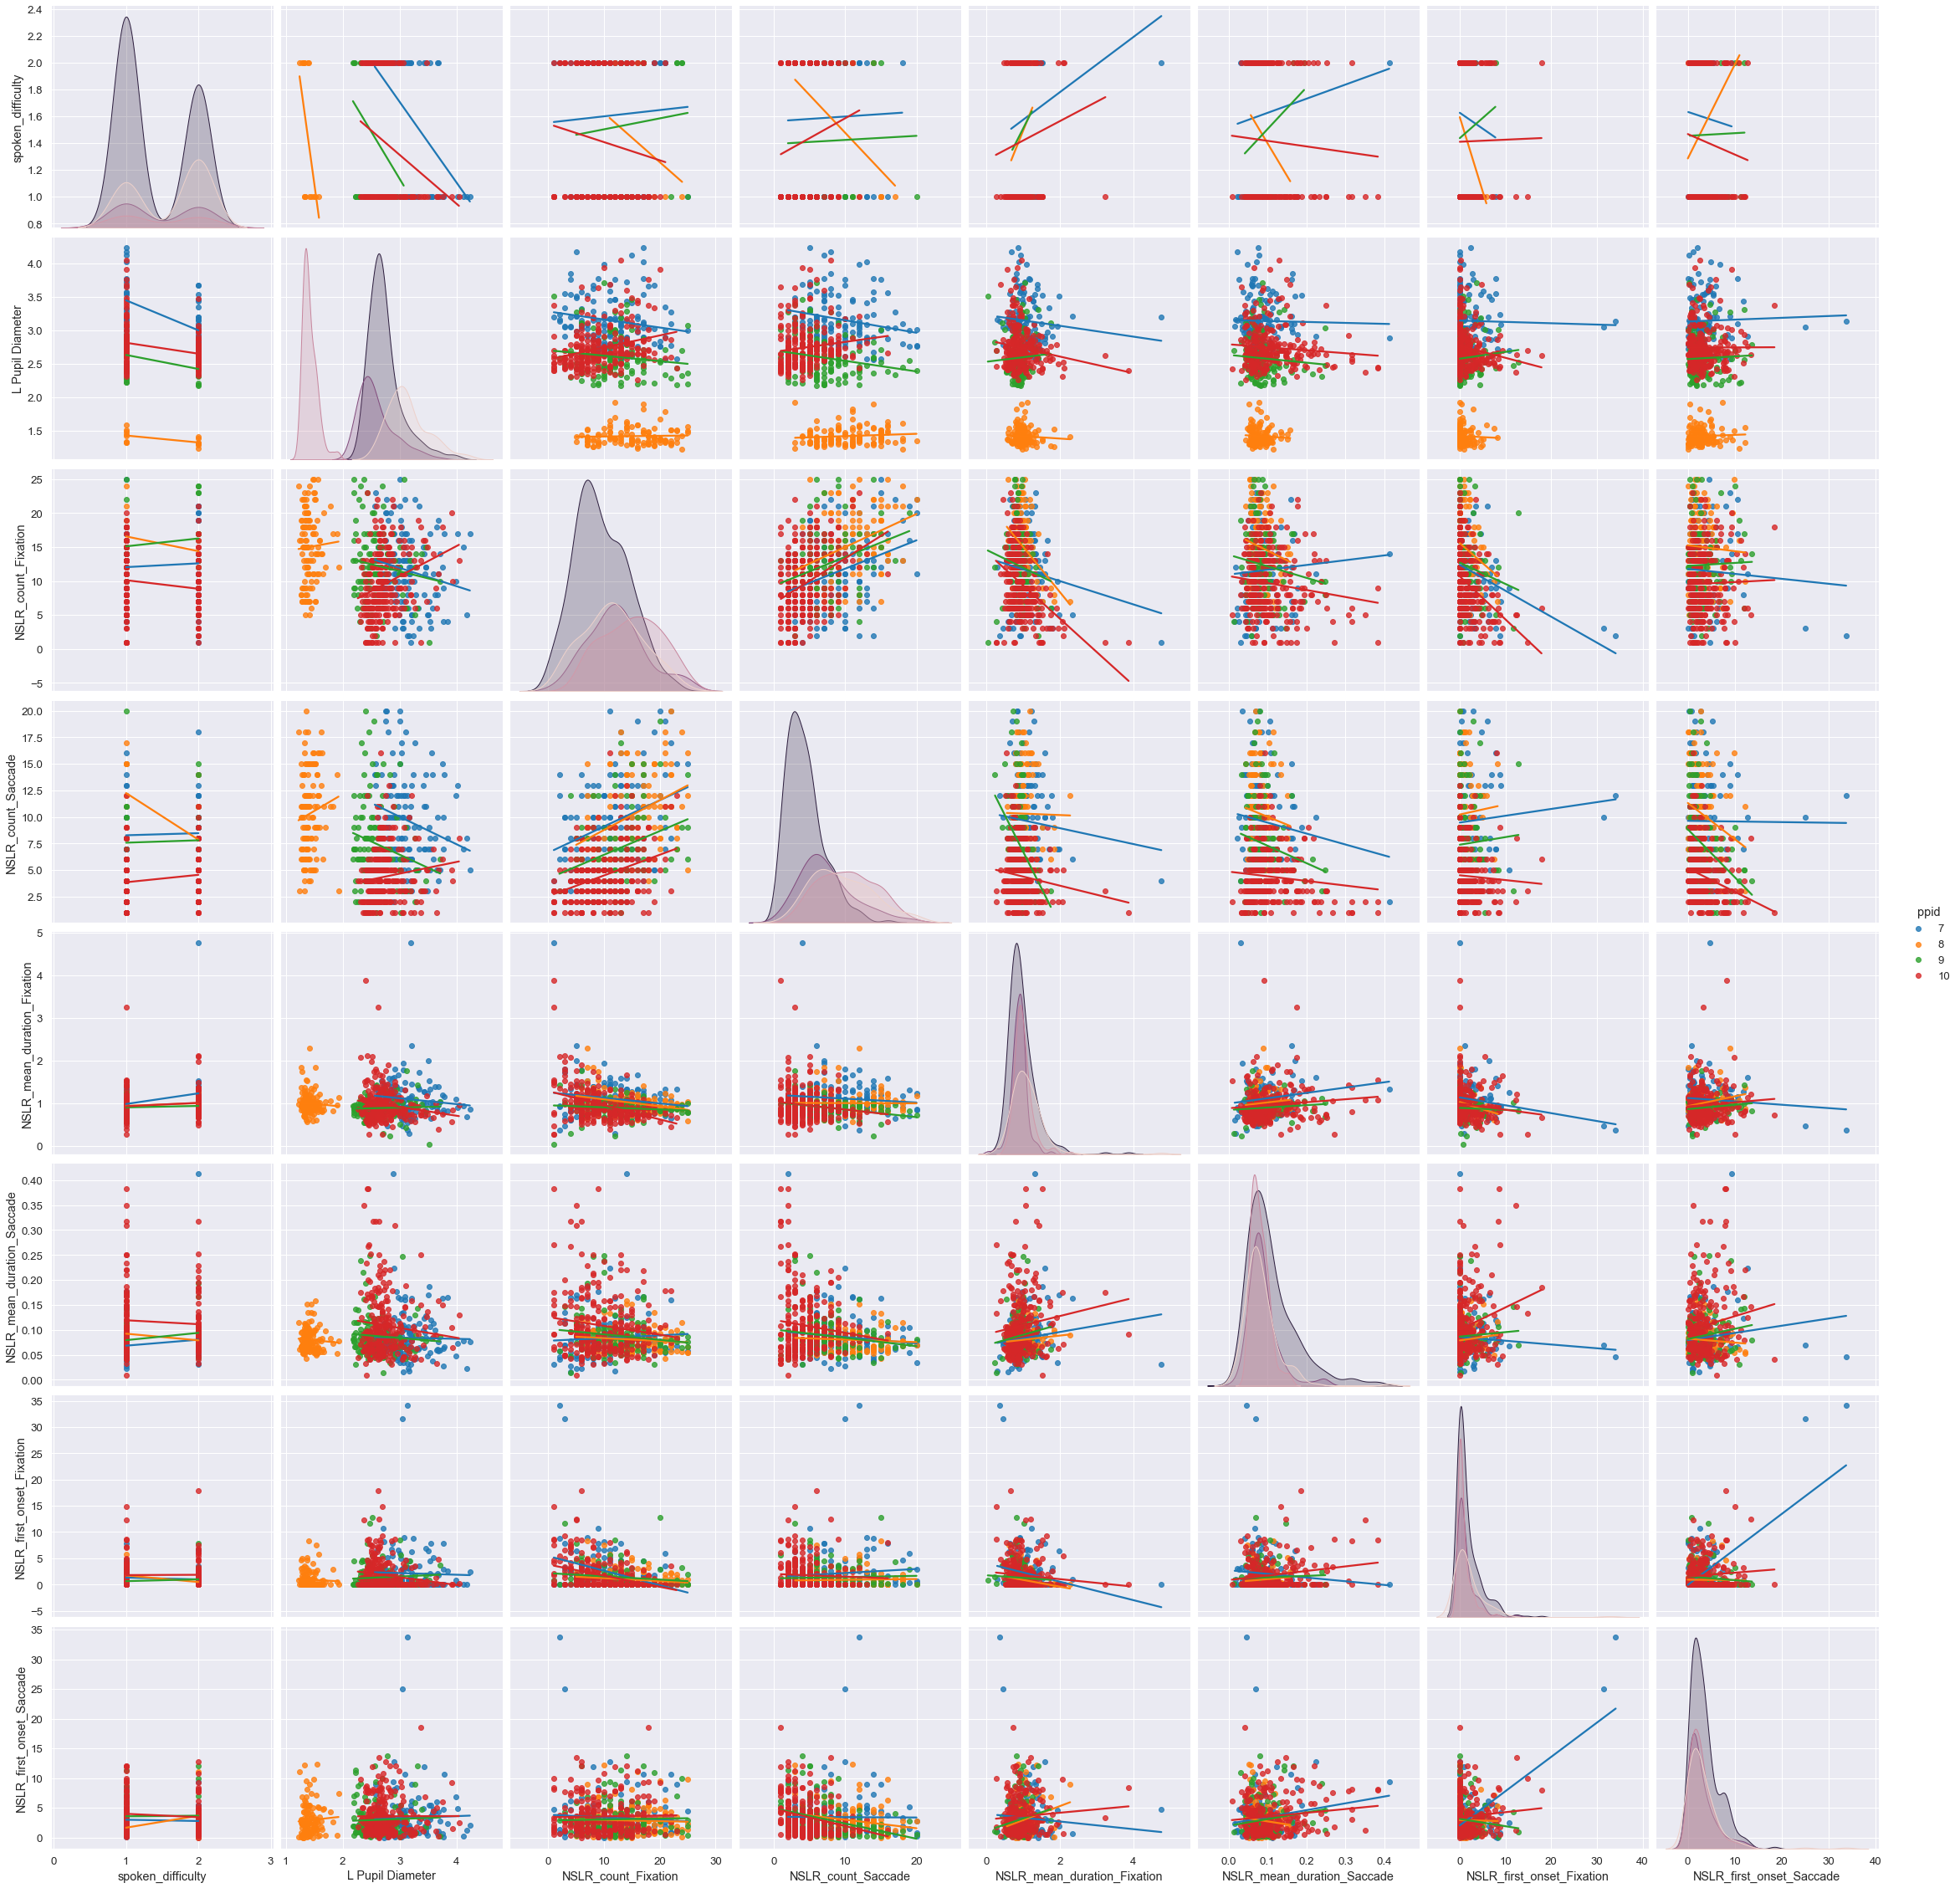

In [145]:
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'unknown', 'spoken_difficulty'] = np.NAN

all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)
#g = sns.pairplot(all_dfs_final[experimental_cols+['ppid_session']], kind="reg", vars=experimental_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

# eye cols
saccade_cols = ['spoken_difficulty', 'density',"NSLR_count_Saccade",'NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Saccade']
#g = sns.pairplot(all_dfs_final[saccade_cols+['ppid_session']], kind="reg", vars=saccade_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

#g = sns.pairplot(all_dfs_final[ecg_cols+['ppid_session']], kind="reg", vars=ecg_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

g = sns.pairplot(all_dfs_final[eye_cols+['ppid']], kind="reg", vars=eye_cols,
                 diag_kind="kde",height=4, hue="ppid", plot_kws=dict(ci=None))

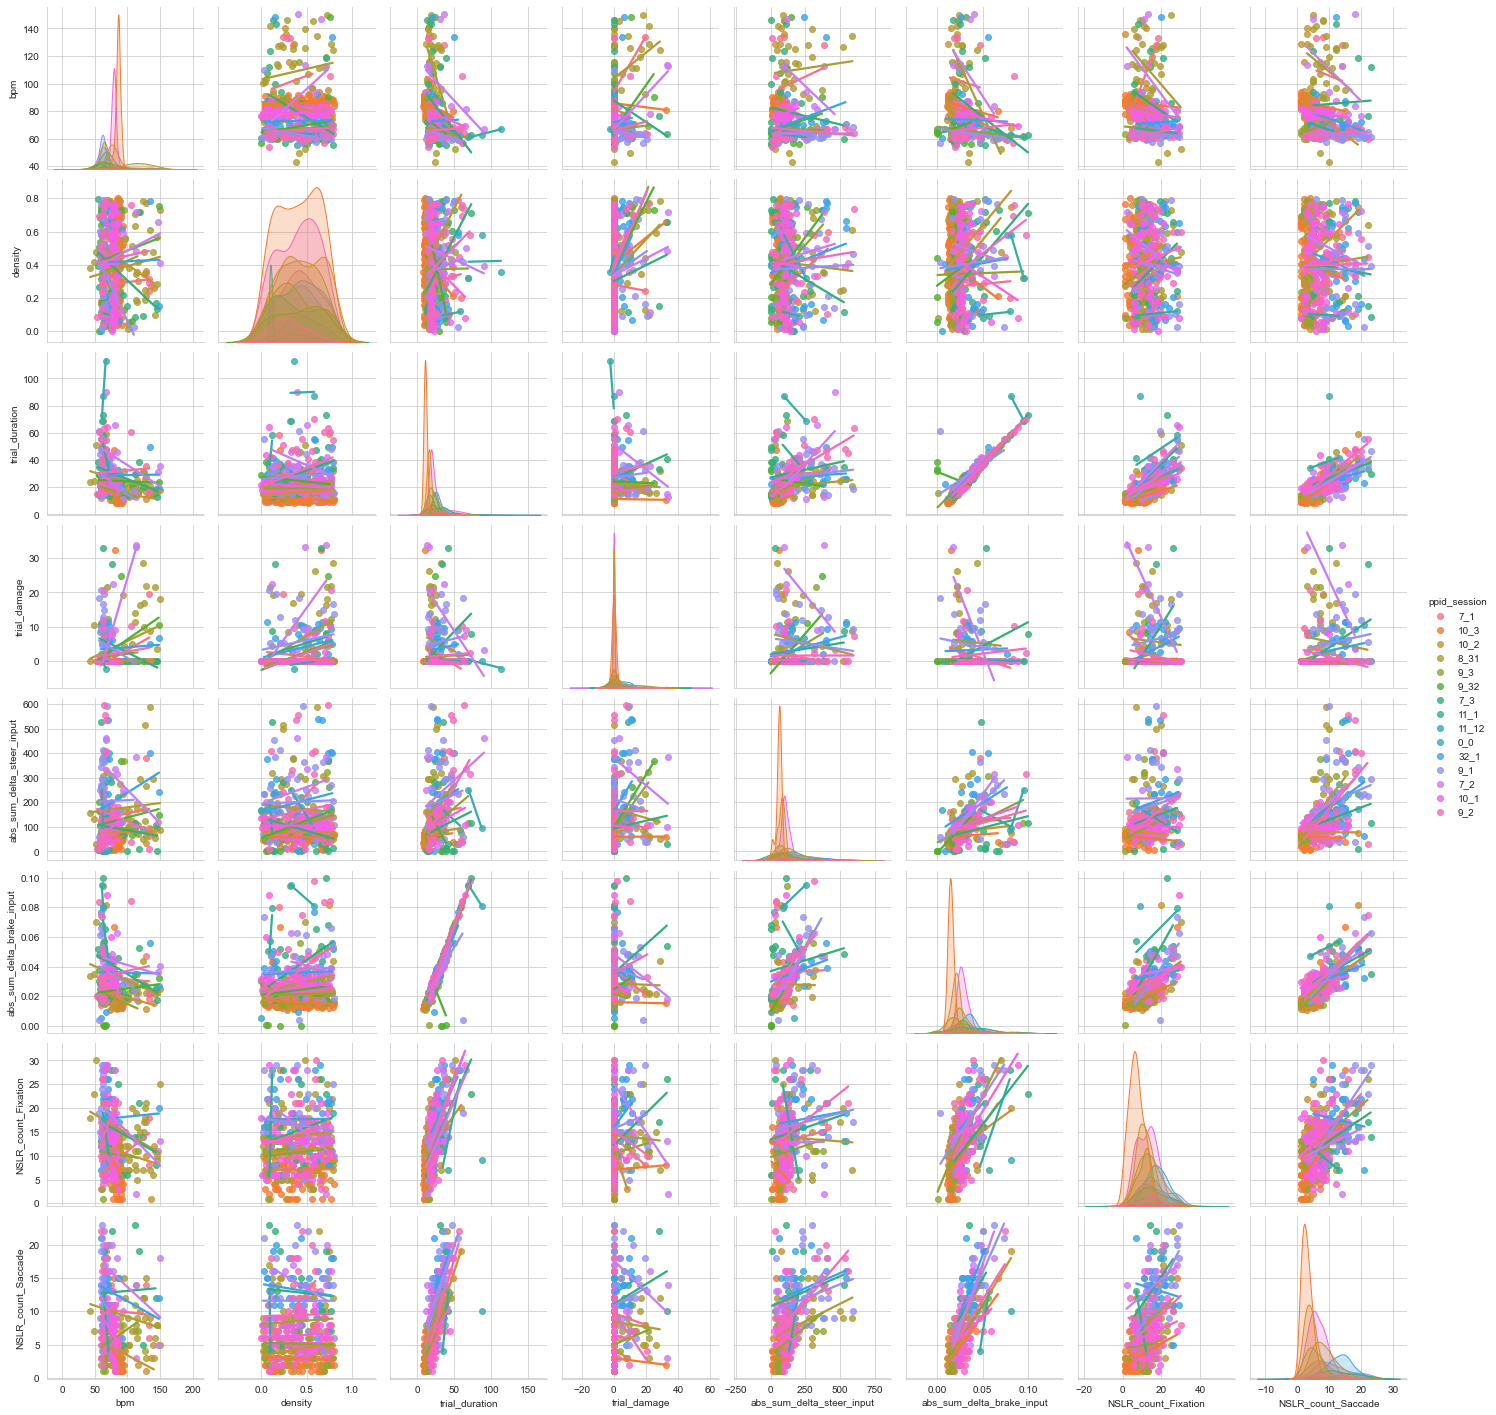

In [58]:
import seaborn as sns
g = sns.pairplot(all_dfs_final, kind="reg", vars=cols_of_interest,
                 diag_kind="kde",height=2.5, hue="ppid_session", plot_kws=dict(ci=None))



In [29]:
all_dfs_final[eye_cols+['ppid_session']].groupby('ppid_session').describe()

spoken_difficulty                                               \
                         count      mean       std  min  25%  50%  75%  max   
ppid_session                                                                  
2_2                       83.0  1.337349  0.475679  1.0  1.0  1.0  2.0  2.0   
3_2                       17.0  1.470588  0.514496  1.0  1.0  1.0  2.0  2.0   
4_3                       18.0  1.166667  0.383482  1.0  1.0  1.0  1.0  2.0   
5_2                       29.0  1.310345  0.470824  1.0  1.0  1.0  2.0  2.0   
6_2                       50.0  1.380000  0.490314  1.0  1.0  1.0  2.0  2.0   
6_3                       48.0  1.562500  0.501328  1.0  1.0  2.0  2.0  2.0   

             NSLR_count_Fixation             ... NSLR_first_onset_Fixation  \
                           count       mean  ...                       75%   
ppid_session                                 ...                             
2_2                        132.0   9.931818  ...                  1.032690   
3_2                         46.0  12.347826  ...                  1.560218   
4_3                         57.0  12.736842  ...                  3.341436   
5_2                         44.0  12.568182  ...                  1.205245   
6_2                         81.0   9.444444  ...                  1.435601   
6_3                         77.0  10.506494  ...                  1.362293   

                        NSLR_first_onset_Saccade                      \
                    max                    count      mean       std   
ppid_session                                                           
2_2           14.787956                    132.0  4.347648  4.527639   
3_2            6.297363                     51.0  3.820324  2.884998   
4_3           12.325783                     58.0  2.859397  2.603268   
5_2           11.874446                     44.0  2.587108  2.895395   
6_2           19.121308                     82.0  3.837152  3.410960   
6_3           32.557569                     73.0  4.263484  3.403111   

                                                                 
                   min       25%       50%       75%        max  
ppid_session                                                     
2_2           0.001241  0.931135  2.266251  7.073613  17.073931  
3_2           0.262880  1.276569  2.813184  5.500166  10.982025  
4_3           0.316842  1.027845  2.118880  3.965141  16.169133  
5_2           0.007086  0.780555  1.475644  3.283021  14.040846  
6_2           0.002236  1.249268  2.949356  5.401182  18.738049  
6_3           0.001800  1.443549  3.533131  6.814372  14.122717  

[6 rows x 56 columns]